# Preliminary analysis

The aim here is to find the different factors that have a significant impact on the performances of roaring bitmaps operations.
We only focus on one operation, the union between two roaring bitmaps.

We consider the following (boolean) factors:
  - dense1 (resp. dense2): true if the elements of the first (resp. second) roaring bitmap are sampled in an interval of size 3*N/2, false if they are sampled in an interval of size 2^6*N (N being the number of elements).
  - copy_on_write: true if the copy on write optimization is used for the two roaring bitmaps (if the optimization is used and the result has a container with the same content than one of the operands' containers, then it uses a reference to this container and no copy is done).
  - run_containers: true if the function `run_optimize` is used before computing the union. This function triggers  a check on all the containers to see if a container conversion is required (from bitset/array to run or from run to bitset/array). Note that run containers may still be used even without this function call.
  - amalgamation: true if the library is amalgamated before the compilation. This means that all the *.c (resp. *.h) files are concatenated into a single roaring.c file (resp. roaring.h). This may help the compiler to perform better optimizations.
  - gcc_optimization: true if the library as well as the test code is compiled with `-O3` option, false it they are compiled with `-O0` option.
  - avx_enabled: true if AVX instructions are used (vector instructions, e.g. to perform in parallel an addition on eight 32 bits integers).
  
These other factors have also been considered in a previous experiment. They are set to True in the following.
  - large1 (resp. large2): true if the first (resp. second) roaring bitmap has (approximately) 2^20 elements, false if it has (approximately) 2^4 elements.
  - gcc_optimization: true if the library as well as the test code is compiled with `-O3` option, false it they are compiled with `-O0` option.
The reason for that is that we mostly care about large bitmaps (they are obviously the ones that take the longer time), and the code will anyway be compiled with `-O3` option when used in production.

All results of this section are in one of the files `results/broadwell_preliminary_results.csv` or `results/skylake_preliminary_results.csv`, depending on the machine used to get them. They have been generated with the following command:
```bash
export LD_LIBRARY_PATH="`pwd`/build/:$LD_LIBRARY_PATH"
./scripts/preliminary_runner.py -n 512 results.csv
```

It runs 512 experiments. For each experiment, every factor is randomly set to true or false with equal probability.

In [1]:
library(ggplot2)
suppressWarnings(suppressMessages(library(FrF2))) # FrF2 outputs a bunch of useless messages...

In [2]:
all_results_broadwell <- read.csv("results/broadwell_preliminary_results.csv")
all_results_skylake <- read.csv("results/skylake_preliminary_results.csv")

In [3]:
get_aov <- function(results, dense1, dense2) {
    subresults <- results[results["dense1"]==dense1 & results["dense2"]==dense2,]
    return(aov(time~(copy_on_write+run_containers+amalgamation+avx_enabled)^2, data=subresults))
}

plot_aov <- function(aov_results) {
    MEPlot(aov_results, abbrev=4, select=c(1, 2, 3, 4), response="time")
    IAPlot(aov_results, abbrev=4, show.alias=FALSE, select=c(1, 2, 3, 4))
}

## Dense datasets

### Broadwell

In [4]:
dense_broadwell_aov <- get_aov(all_results_broadwell, "True", "True")
summary(dense_broadwell_aov)

                              Df    Sum Sq   Mean Sq   F value   Pr(>F)    
copy_on_write                  1 0.0000000 0.0000000 3.080e-01   0.5798    
run_containers                 1 0.0007362 0.0007362 4.348e+05  < 2e-16 ***
amalgamation                   1 0.0000000 0.0000000 2.150e-01   0.6436    
avx_enabled                    1 0.0000001 0.0000001 8.198e+01 3.65e-15 ***
copy_on_write:run_containers   1 0.0000000 0.0000000 4.170e-01   0.5199    
copy_on_write:amalgamation     1 0.0000000 0.0000000 5.570e-01   0.4568    
copy_on_write:avx_enabled      1 0.0000000 0.0000000 1.407e+00   0.2380    
run_containers:amalgamation    1 0.0000000 0.0000000 5.400e-02   0.8167    
run_containers:avx_enabled     1 0.0000001 0.0000001 8.396e+01 2.03e-15 ***
amalgamation:avx_enabled       1 0.0000000 0.0000000 2.993e+00   0.0863 .  
Residuals                    117 0.0000002 0.0000000                       
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

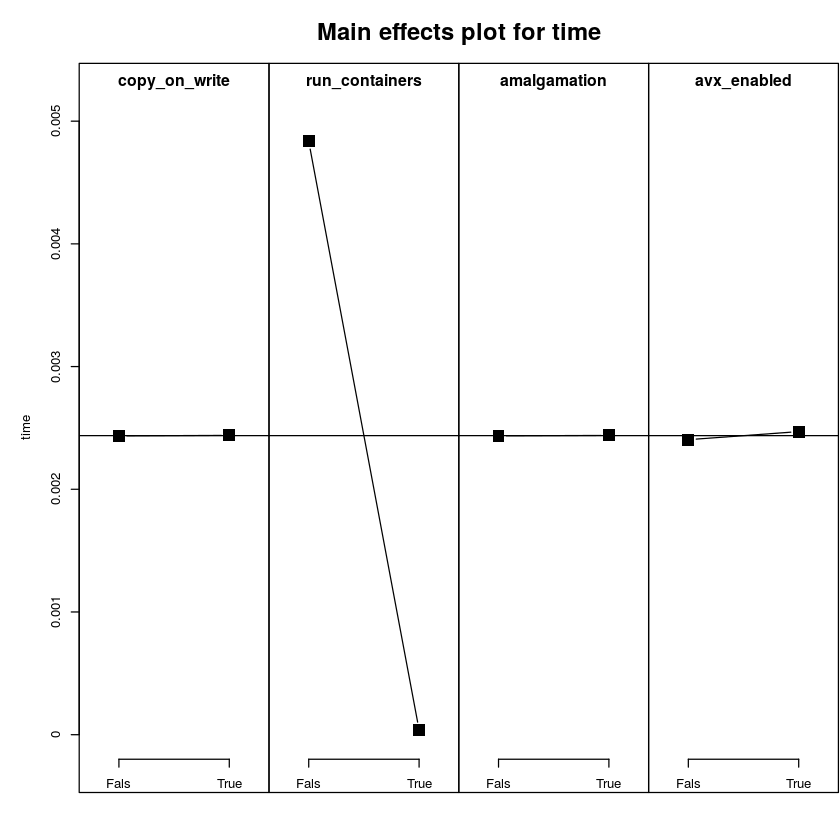

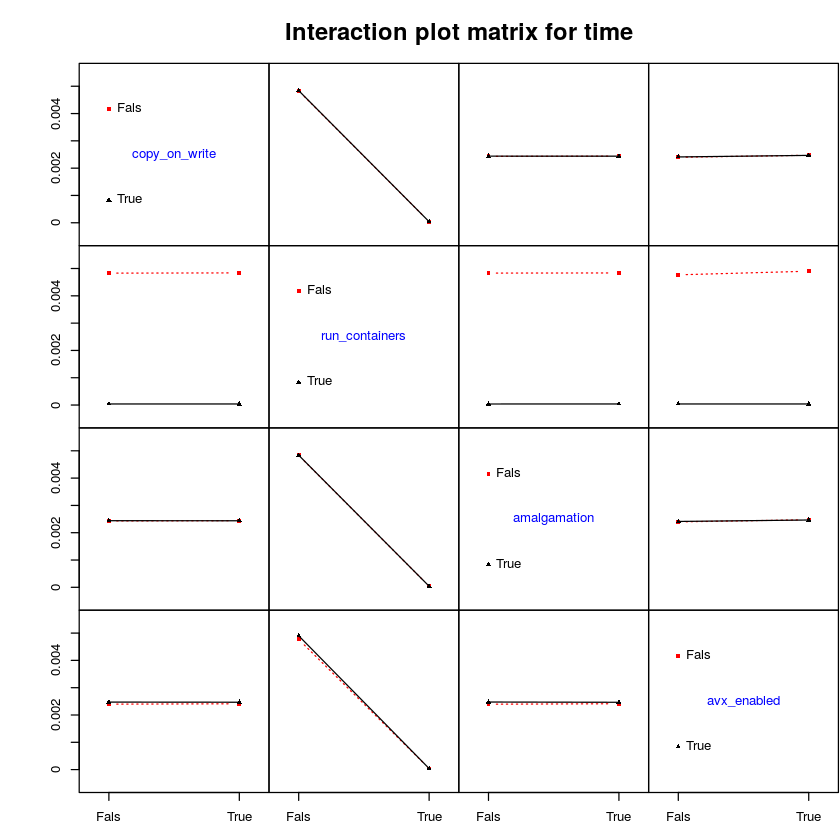

In [5]:
plot_aov(dense_broadwell_aov)

### Skylake

In [6]:
dense_skylake_aov <- get_aov(all_results_skylake, "True", "True")
summary(dense_skylake_aov)

                              Df    Sum Sq  Mean Sq   F value   Pr(>F)    
copy_on_write                  1 0.0000000 0.000000 1.516e+00    0.219    
run_containers                 1 0.0013370 0.001337 3.462e+06  < 2e-16 ***
amalgamation                   1 0.0000000 0.000000 2.298e+01 2.84e-06 ***
avx_enabled                    1 0.0000000 0.000000 2.478e+00    0.117    
copy_on_write:run_containers   1 0.0000000 0.000000 2.574e+00    0.110    
copy_on_write:amalgamation     1 0.0000000 0.000000 4.700e-02    0.828    
copy_on_write:avx_enabled      1 0.0000000 0.000000 1.140e+00    0.287    
run_containers:amalgamation    1 0.0000000 0.000000 2.629e+01 5.97e-07 ***
run_containers:avx_enabled     1 0.0000000 0.000000 4.660e-01    0.496    
amalgamation:avx_enabled       1 0.0000000 0.000000 1.769e+00    0.185    
Residuals                    245 0.0000001 0.000000                       
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

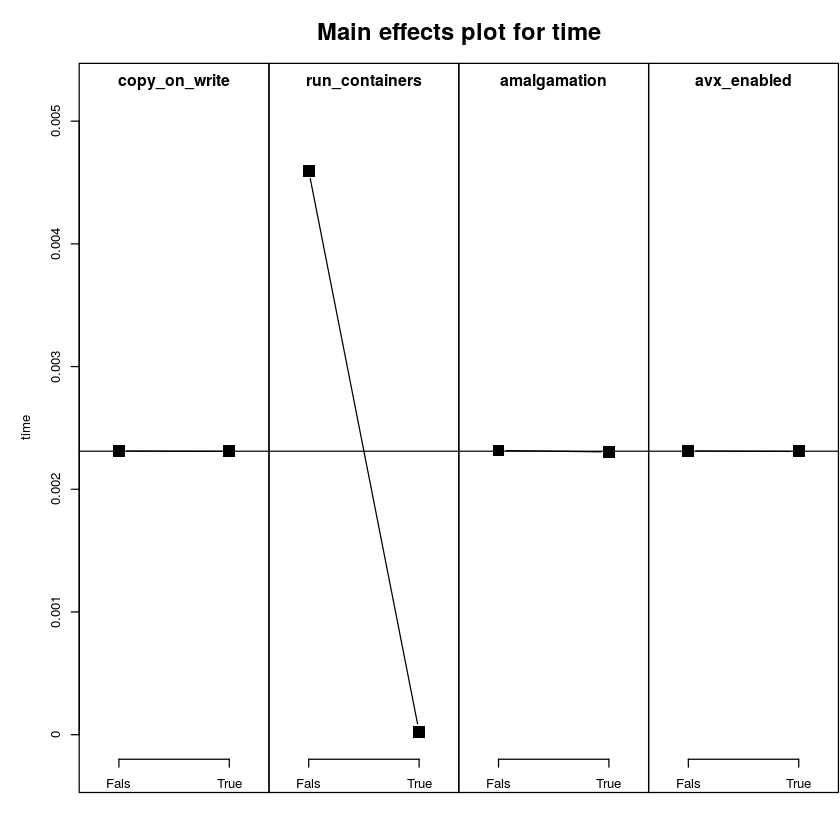

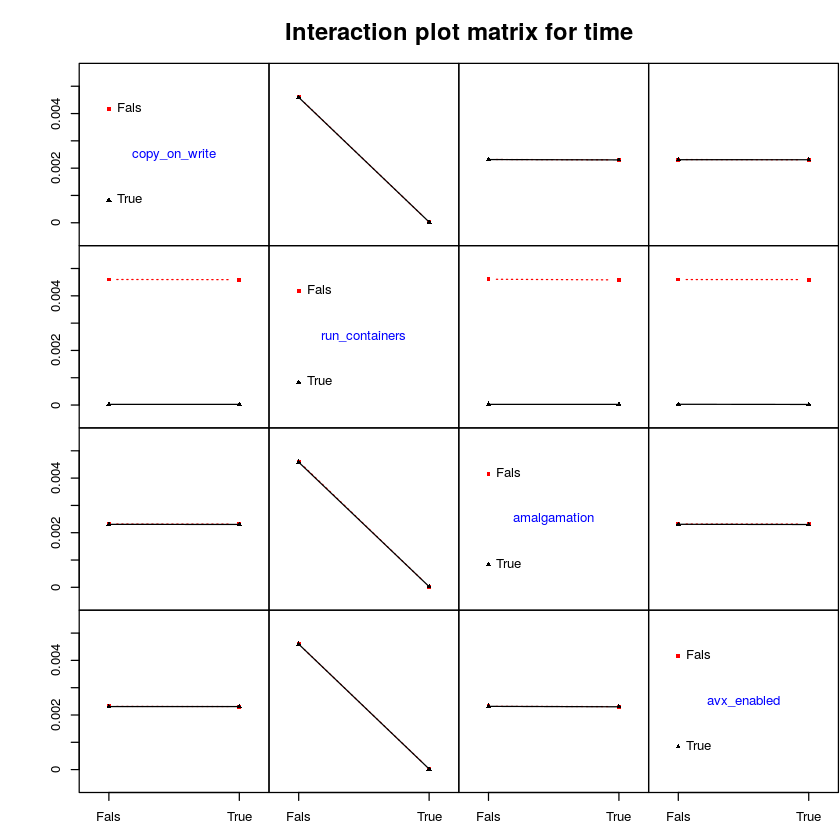

In [7]:
plot_aov(dense_skylake_aov)

It is clear that the factor `run_containers` have a very large positive impact when set to True, for both the Broadwell and the Skylake machines. In this case, one should definitely call the function `run_optimize` before computing the union.

We can also notice a significant negative impact of the factor `avx_enabled` on the Broadwell machine, and a significant positive impact of the factor `amalgamation` on the Skylake machine.

Other factors have a negligible impact.

## Sparse datasets

### Broadwell

In [8]:
sparse_broadwell_aov <- get_aov(all_results_broadwell, "False", "False")
summary(sparse_broadwell_aov)

                              Df   Sum Sq  Mean Sq   F value   Pr(>F)    
copy_on_write                  1 0.00e+00 0.00e+00     0.002    0.963    
run_containers                 1 0.00e+00 0.00e+00     0.051    0.822    
amalgamation                   1 1.20e-06 1.20e-06    32.971 7.52e-08 ***
avx_enabled                    1 1.29e-03 1.29e-03 35634.417  < 2e-16 ***
copy_on_write:run_containers   1 1.00e-07 1.00e-07     2.563    0.112    
copy_on_write:amalgamation     1 0.00e+00 0.00e+00     0.242    0.624    
copy_on_write:avx_enabled      1 1.00e-07 1.00e-07     1.950    0.165    
run_containers:amalgamation    1 0.00e+00 0.00e+00     1.051    0.307    
run_containers:avx_enabled     1 1.00e-07 1.00e-07     2.365    0.127    
amalgamation:avx_enabled       1 9.00e-07 9.00e-07    25.561 1.60e-06 ***
Residuals                    117 4.20e-06 0.00e+00                       
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

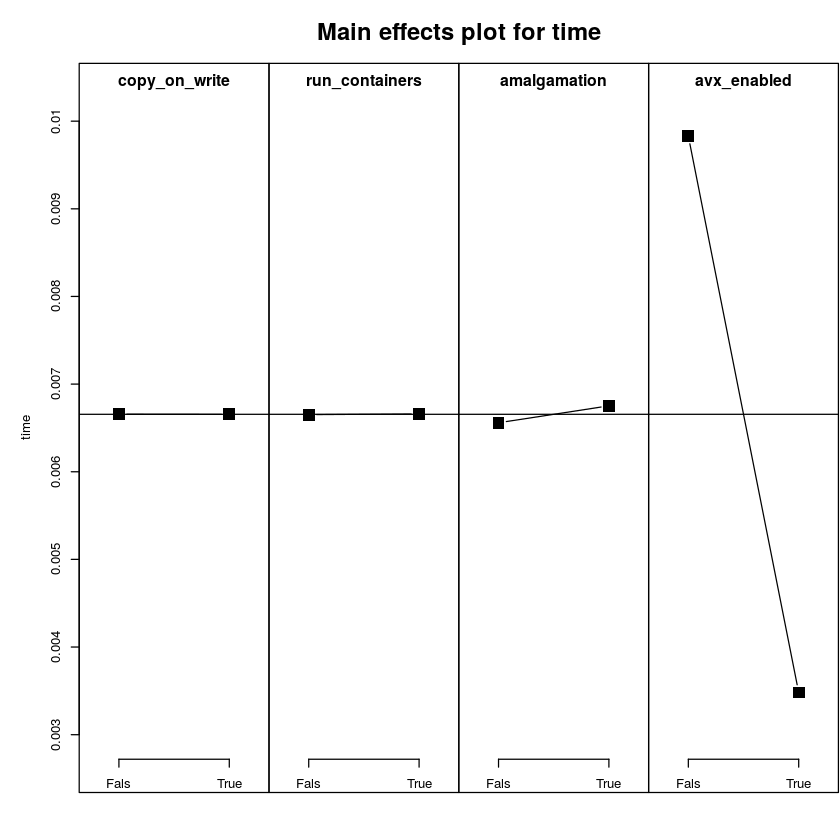

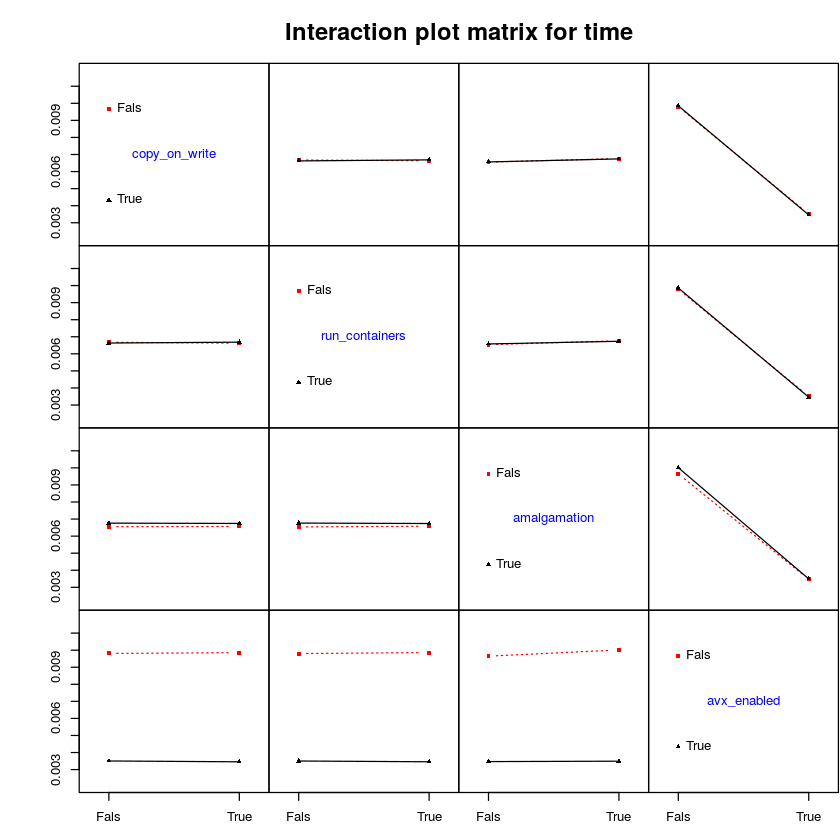

In [9]:
plot_aov(sparse_broadwell_aov)

### Skylake

In [10]:
sparse_skylake_aov <- get_aov(all_results_skylake, "False", "False")
summary(sparse_skylake_aov)

                              Df    Sum Sq   Mean Sq   F value   Pr(>F)    
copy_on_write                  1 0.0000000 0.0000000 0.000e+00    0.987    
run_containers                 1 0.0000000 0.0000000 1.877e+00    0.172    
amalgamation                   1 0.0000005 0.0000005 7.543e+01 5.44e-16 ***
avx_enabled                    1 0.0027290 0.0027290 4.421e+05  < 2e-16 ***
copy_on_write:run_containers   1 0.0000000 0.0000000 5.050e-01    0.478    
copy_on_write:amalgamation     1 0.0000000 0.0000000 8.300e-02    0.773    
copy_on_write:avx_enabled      1 0.0000000 0.0000000 1.349e+00    0.247    
run_containers:amalgamation    1 0.0000000 0.0000000 6.100e-02    0.805    
run_containers:avx_enabled     1 0.0000000 0.0000000 1.359e+00    0.245    
amalgamation:avx_enabled       1 0.0000004 0.0000004 6.117e+01 1.56e-13 ***
Residuals                    245 0.0000015 0.0000000                       
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

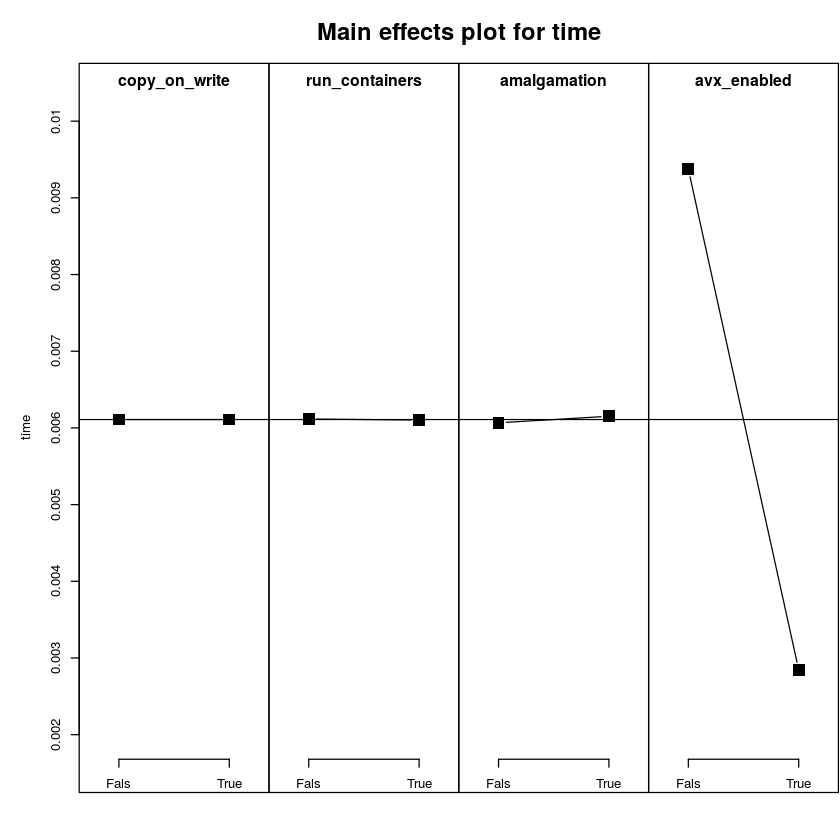

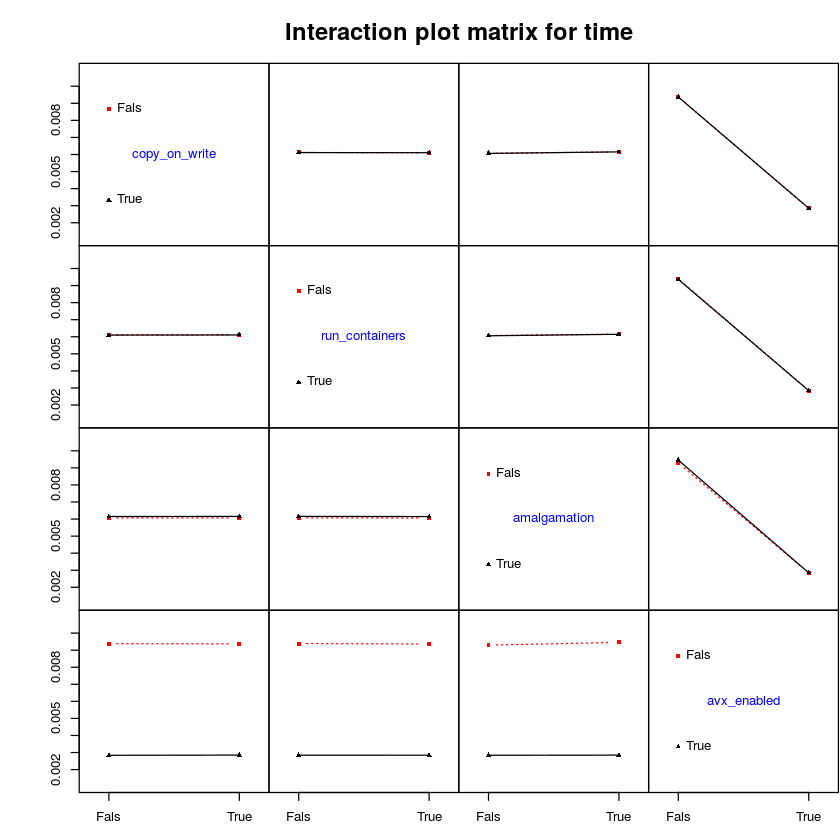

In [11]:
plot_aov(sparse_skylake_aov)

For both machines, the factor `AVX_enabled` has a very large positive impact. In this case, one should therefore not disable the AVX optimizations of the library.

We also see that `amalgamation` has a noticeable negative impact. However, this impact is larger when AVX is disabled. So if we chose not to disable it, using amalgamation or not should not matter.

## Large and one-dense datasets

Here, one and only one of the datasets is `dense`.

In [12]:
get_onedense_aov <- function(results) {
    subresults <- results[(results["dense1"]=="True" | results["dense2"]=="True") & (results["dense1"]=="False" | results["dense2"]=="False"),]
    return(aov(time~(copy_on_write+run_containers+amalgamation+avx_enabled)^2, data=subresults))
}

In [13]:
onedense_broadwell_aov <- get_onedense_aov(all_results_broadwell)
summary(onedense_broadwell_aov)

                              Df    Sum Sq   Mean Sq   F value   Pr(>F)    
copy_on_write                  1 0.0000323 0.0000323  4274.852  < 2e-16 ***
run_containers                 1 0.0003448 0.0003448 45685.691  < 2e-16 ***
amalgamation                   1 0.0000001 0.0000001     8.342  0.00422 ** 
avx_enabled                    1 0.0000012 0.0000012   152.841  < 2e-16 ***
copy_on_write:run_containers   1 0.0000002 0.0000002    29.974 1.08e-07 ***
copy_on_write:amalgamation     1 0.0000000 0.0000000     0.047  0.82818    
copy_on_write:avx_enabled      1 0.0000000 0.0000000     0.344  0.55815    
run_containers:amalgamation    1 0.0000001 0.0000001     8.668  0.00355 ** 
run_containers:avx_enabled     1 0.0000014 0.0000014   186.016  < 2e-16 ***
amalgamation:avx_enabled       1 0.0000001 0.0000001     6.723  0.01009 *  
Residuals                    245 0.0000018 0.0000000                       
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

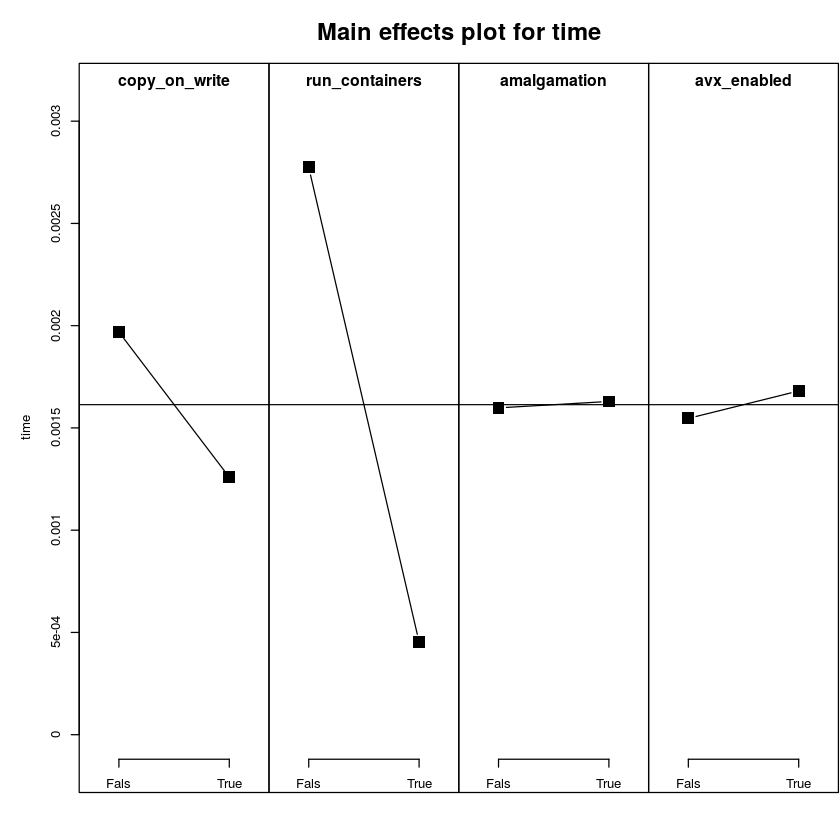

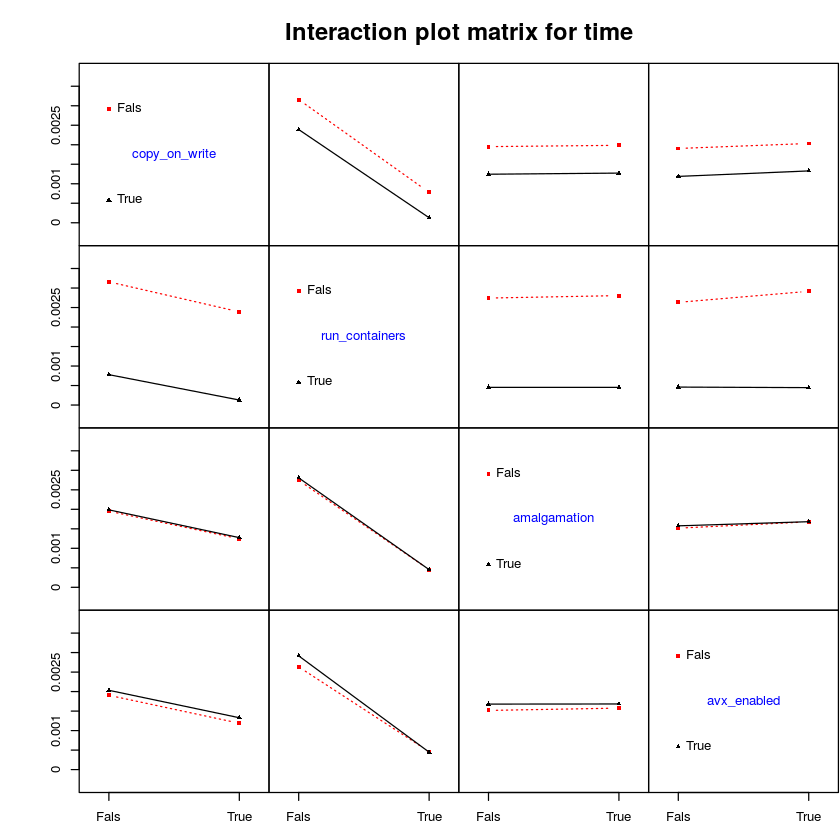

In [14]:
plot_aov(onedense_broadwell_aov)

In [15]:
onedense_skylake_aov <- get_onedense_aov(all_results_skylake)
summary(onedense_skylake_aov)

                              Df    Sum Sq   Mean Sq   F value   Pr(>F)    
copy_on_write                  1 0.0000282 0.0000282 5.958e+03  < 2e-16 ***
run_containers                 1 0.0004935 0.0004935 1.043e+05  < 2e-16 ***
amalgamation                   1 0.0000001 0.0000001 1.414e+01 0.000189 ***
avx_enabled                    1 0.0000002 0.0000002 3.866e+01 1.06e-09 ***
copy_on_write:run_containers   1 0.0000003 0.0000003 6.661e+01 2.69e-15 ***
copy_on_write:amalgamation     1 0.0000000 0.0000000 7.700e-02 0.781171    
copy_on_write:avx_enabled      1 0.0000000 0.0000000 6.700e-02 0.796536    
run_containers:amalgamation    1 0.0000000 0.0000000 8.917e+00 0.002964 ** 
run_containers:avx_enabled     1 0.0000001 0.0000001 1.785e+01 2.84e-05 ***
amalgamation:avx_enabled       1 0.0000001 0.0000001 1.768e+01 3.09e-05 ***
Residuals                    501 0.0000024 0.0000000                       
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

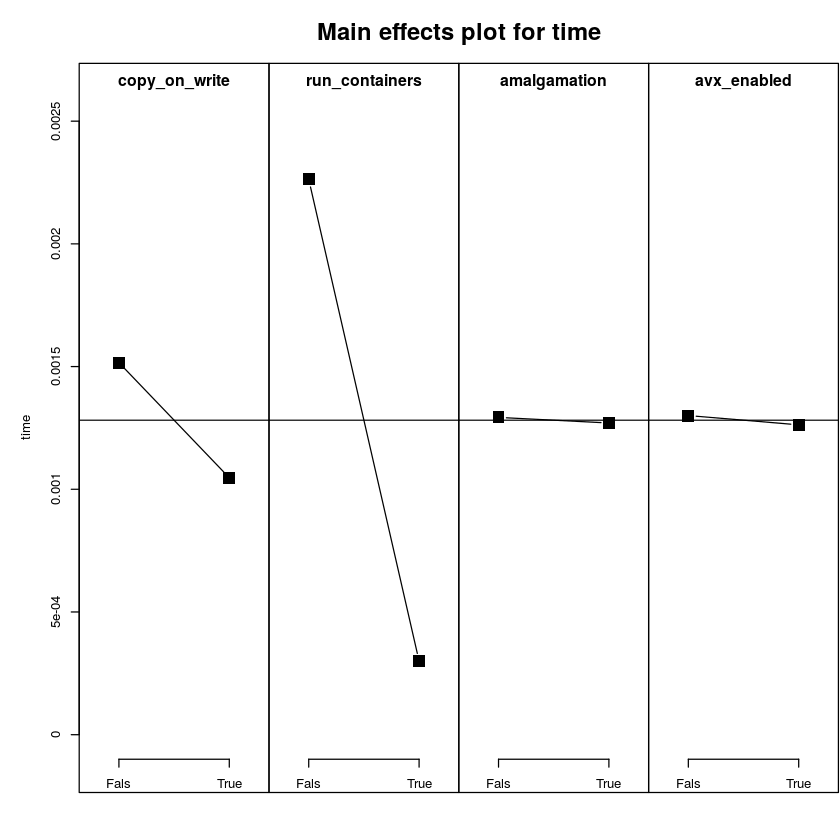

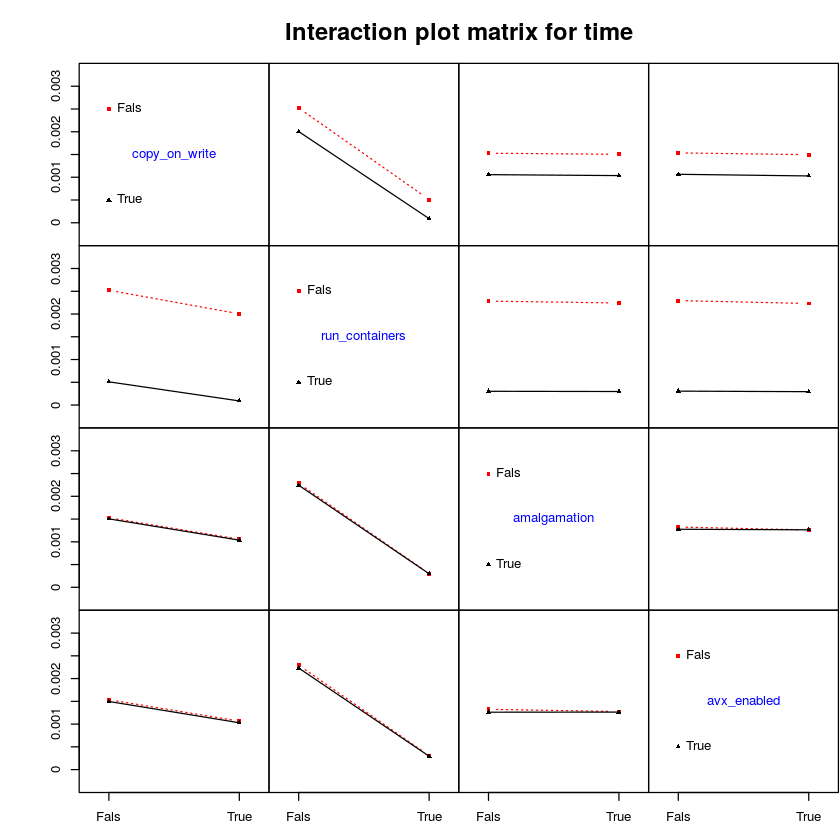

In [16]:
plot_aov(onedense_skylake_aov)

In this case, for both machines, all factors have a non-negligible impact on performances.

The factors `run_containers` and `copy_on_write` are the most impactfull: they both greatly improve the performances when set to `True`. Also, these two factors have an high interaction.

What is surprising is that `amalgamation` and `avx_enabled` both have a significant negative impact with the Broadwell machine, and a significant positive impact with the `Skylake` machine.

## Conclusion

We have seen that the factors having the highest impact are not always the same: it depends on the nature of the datasets. This is expected, since the container will change accordingly. For dense datasets, bitset and run containers are more likely to be used, whereas for sparse datasets array containers will be used.

For dense datasets, calling the function `run_optimize` will get the best improvement in performances.

For sparse datasets, the best improvement can be obtained by compiling the library with AVX instructions enabled (this is the case by default).

When one of the datasets is sparse and the other is dense, calling `run_optimize` and enabling copy on write will get the highest gain.